# Search for Runaways



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import os
os.getcwd()

'/home/kevin_leo_mcmanus/repos/runawaysearch'

## Load up Stars, Cluster Info

In [3]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [4]:
# gaiadr2 to gaiaedr3 mapper
from  gaiastars import gaiadr2xdr3

In [5]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)

In [6]:
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [7]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

Text(0.5, 0.98, 'Color-Magnitude Diagrams of Known Members')

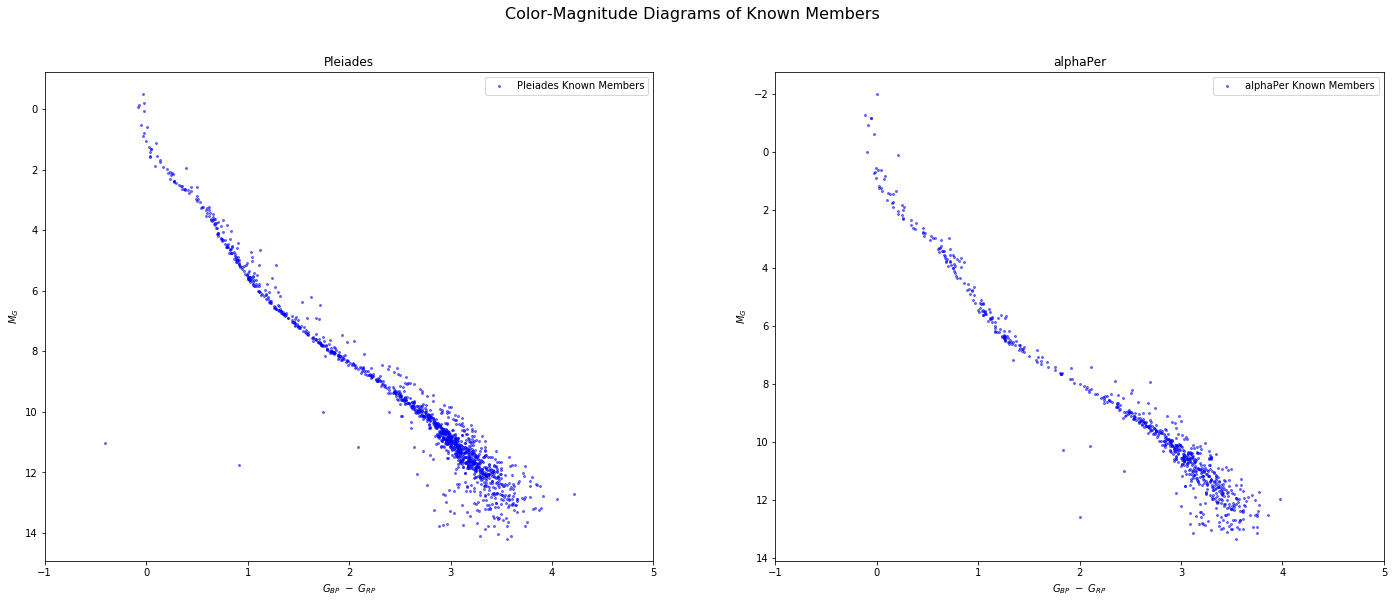

In [8]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    #search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=4)
    ax[i].set_title(cl, size=12)
    ax[i].legend()
    
fig.suptitle("Color-Magnitude Diagrams of Known Members", size=16)

## Collect GAIA Sample Data

In [9]:
cluster_names = ['Pleiades', 'alphaPer']
search_results = {}

from gaiastars import from_pickle

for cl in cluster_names:
    search_results[cl] = from_pickle(f'./data/search_results_{cl}.pkl')


In [10]:
#exclude the known members returned from the search
for cl in cluster_names:
    merged_fs = search_results[cl].merge(cluster_members[cl])
    print(f'------ {cl} -------')
    print(merged_fs.objs.which.value_counts())
    fs = merged_fs.query('which == \'{} cone search\''.format(cl))
    fs.name = 'Search Results, Known Members excluded'
    search_results[cl] = fs

------ Pleiades -------
Pleiades cone search    107919
both                      1225
Pleiades                   101
Name: which, dtype: int64
------ alphaPer -------
alphaPer cone search    291664
both                       699
alphaPer                    41
Name: which, dtype: int64


Text(0.5, 0.98, 'Sky Position\nSearch Results and Known Members')

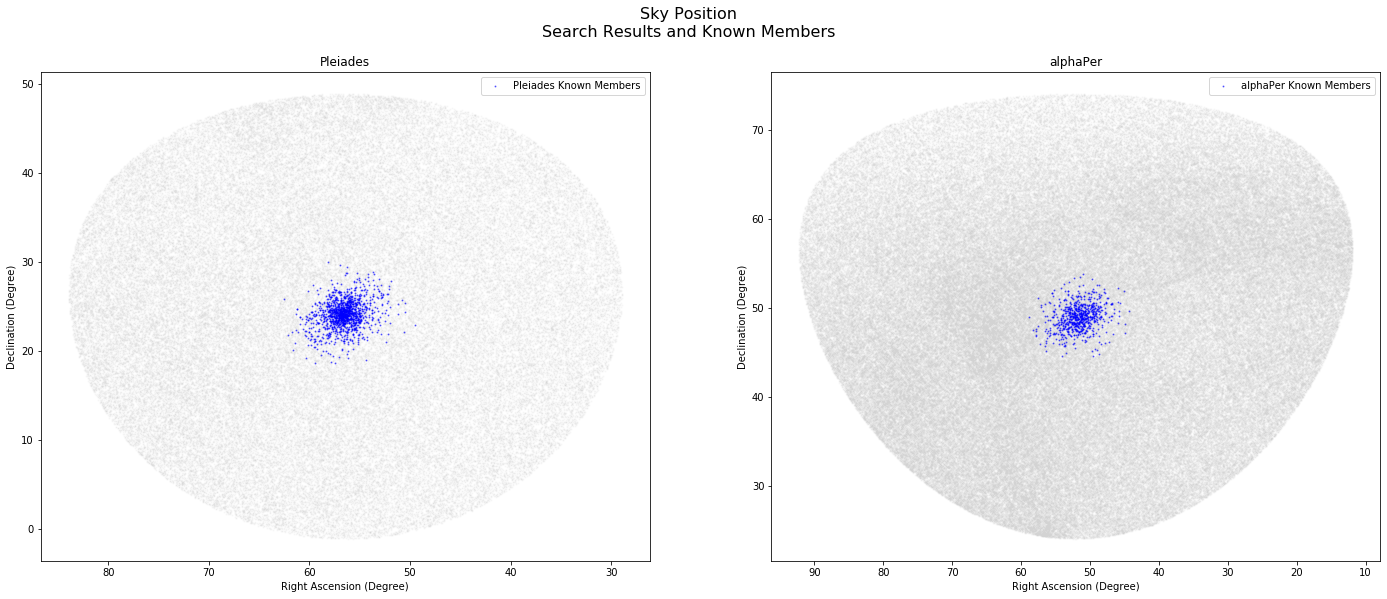

In [11]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    ax[i].scatter(search_results[cl].objs.ra,  search_results[cl].objs.dec, color='lightgrey', alpha=0.1, s=1)
    ax[i].scatter(cluster_members[cl].objs.ra, cluster_members[cl].objs.dec, color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl, size=12)
    ax[i].set_xlabel('Right Ascension (Degree)')
    ax[i].set_ylabel('Declination (Degree)')
    ax[i].legend()
    ax[i].invert_xaxis()
    
fig.suptitle("Sky Position\nSearch Results and Known Members", size=16)

In [12]:
search_results['alphaPer'].tap_query_string

["SELECT  gaiaedr3.gaia_source.source_id, gaiaedr3.gaia_source.ra, gaiaedr3.gaia_source.dec, gaiaedr3.gaia_source.parallax, gaiaedr3.gaia_source.pmra, gaiaedr3.gaia_source.pmdec, gaiaedr3.gaia_source.dr2_radial_velocity, gaiaedr3.gaia_source.phot_g_mean_mag, gaiaedr3.gaia_source.phot_bp_mean_mag, gaiaedr3.gaia_source.phot_rp_mean_mag, gaiaedr3.gaia_source.ruwe, gaiaedr3.gaia_source.ra_error, gaiaedr3.gaia_source.dec_error, gaiaedr3.gaia_source.parallax_error, gaiaedr3.gaia_source.pmra_error, gaiaedr3.gaia_source.pmdec_error, gaiaedr3.gaia_source.dr2_radial_velocity_error, gaiaedr3.gaia_source.ra_dec_corr, gaiaedr3.gaia_source.ra_parallax_corr, gaiaedr3.gaia_source.ra_pmra_corr, gaiaedr3.gaia_source.ra_pmdec_corr, gaiaedr3.gaia_source.dec_parallax_corr, gaiaedr3.gaia_source.dec_pmra_corr, gaiaedr3.gaia_source.dec_pmdec_corr, gaiaedr3.gaia_source.parallax_pmra_corr, gaiaedr3.gaia_source.parallax_pmdec_corr, gaiaedr3.gaia_source.pmra_pmdec_corr FROM gaiaedr3.gaia_source WHERE CONTAINS(POI

In [13]:
cluster_info.loc['alphaPer']

cluster,ra,dec,U,e_U,V,e_V,W,e_W,cUV,cUW,cVW,ra_conv,dec_conv,plx,e_plx,pmra,e_pmra,pmdec,e_pmdec,NMemb,uwsd,RV,e_RV,coords,DM,log_age,Fe_H,e_b_minus_v,NMembers,Z
,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg,pc",,,,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64
alphaPer,52.06,49.06,-5.11,0.053,24.183000000000003,0.067,-14.122,0.09699999999999999,0.25,0.4,0.59,101.9183,-29.7555,5.718,0.005,22.929000000000002,0.071,-25.555999999999997,0.095,740,0.68,-0.29,0.08,"52.06,49.06,174.88632388947184",6.2139999999999995,7.85,0.14,0.09,598,0.02


In [14]:
from astropy.coordinates import Angle
orion_members = pd.read_csv('./data/OrionMembers.csv', encoding = 'utf8')

# Convert to degrees:
ra_deg = Angle([hms for hms in orion_members.RA], unit="hour")
dec_deg = Angle([d[0:3]+'d'+d[5:7]+'m'+d[9:-1]+'s' for d in orion_members.Dec], unit='degree')

orion_members['RA_deg'] = ra_deg.to_value(u.degree)
orion_members['Dec_deg'] = dec_deg.to_value(u.degree)

dist_pc = (np.array(orion_members.Dist_ly)*u.lightyear).to_value(u.pc)
orion_members['Dist_pc'] = dist_pc
orion_bright = orion_members.query('AppMag <= 4')

In [15]:
def plot_mwd(RA,Dec,org=0,title='Mollweide projection', projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection)
    ax.scatter(np.radians(x),np.radians(Dec))  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

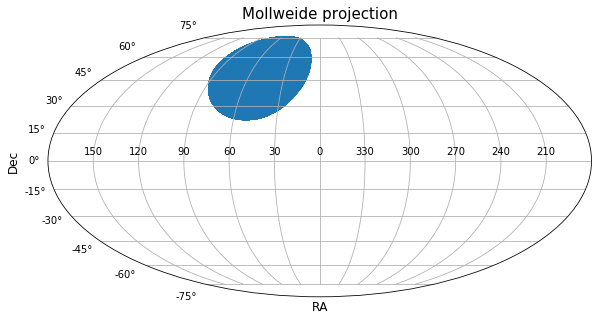

In [16]:
plot_mwd(search_results['alphaPer'].objs.ra, search_results['alphaPer'].objs.dec)

In [19]:
def fix_ra(ra, org=0):
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x
    return x

"\nfor cl in search_results:\n    ax.scatter(cluster_info.loc[cl]['ra'], cluster_info.loc[cl]['dec'], s=100, marker='*')\n    ax.annotate(f'Cluster Center: {cl}',\n                (cluster_info.loc[cl]['ra'], cluster_info.loc[cl]['dec']),\n            xytext=(cluster_info.loc[cl]['ra']-5, cluster_info.loc[cl]['dec']+5), textcoords='data',\n            arrowprops=dict(facecolor='black', shrink=0.05, width=1),\n            horizontalalignment='right', verticalalignment='top',va='bottom')\n\n \nax.legend()\nax.invert_xaxis()\n"

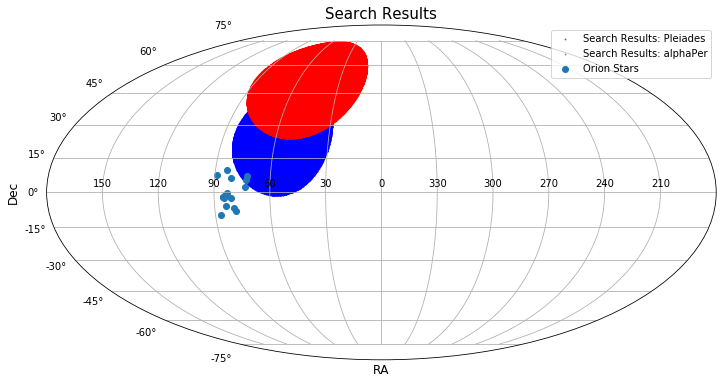

In [21]:
org=0

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='mollweide')

for cl, col in zip(search_results,['blue','red']):
    x = fix_ra(search_results[cl].objs.ra, org=org)
    ax.scatter(np.radians(x), 
               np.radians(search_results[cl].objs.dec), s=1, alpha=0.5,
               color=col, label=f'Search Results: {cl}')
    

x = fix_ra(orion_bright.RA_deg, org=org)
ax.scatter(np.radians(x), np.radians(orion_bright.Dec_deg), label='Orion Stars')  

ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
ax.set_title('Search Results')
ax.title.set_fontsize(15)
ax.set_xlabel("RA")
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel("Dec")
ax.yaxis.label.set_fontsize(12)
ax.grid(True)
ax.legend()
"""
for cl in search_results:
    ax.scatter(cluster_info.loc[cl]['ra'], cluster_info.loc[cl]['dec'], s=100, marker='*')
    ax.annotate(f'Cluster Center: {cl}',
                (cluster_info.loc[cl]['ra'], cluster_info.loc[cl]['dec']),
            xytext=(cluster_info.loc[cl]['ra']-5, cluster_info.loc[cl]['dec']+5), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            horizontalalignment='right', verticalalignment='top',va='bottom')

 
ax.legend()
ax.invert_xaxis()
"""

Text(0.5, 0.98, 'Proper Motion\nSearch Results and Known Members')

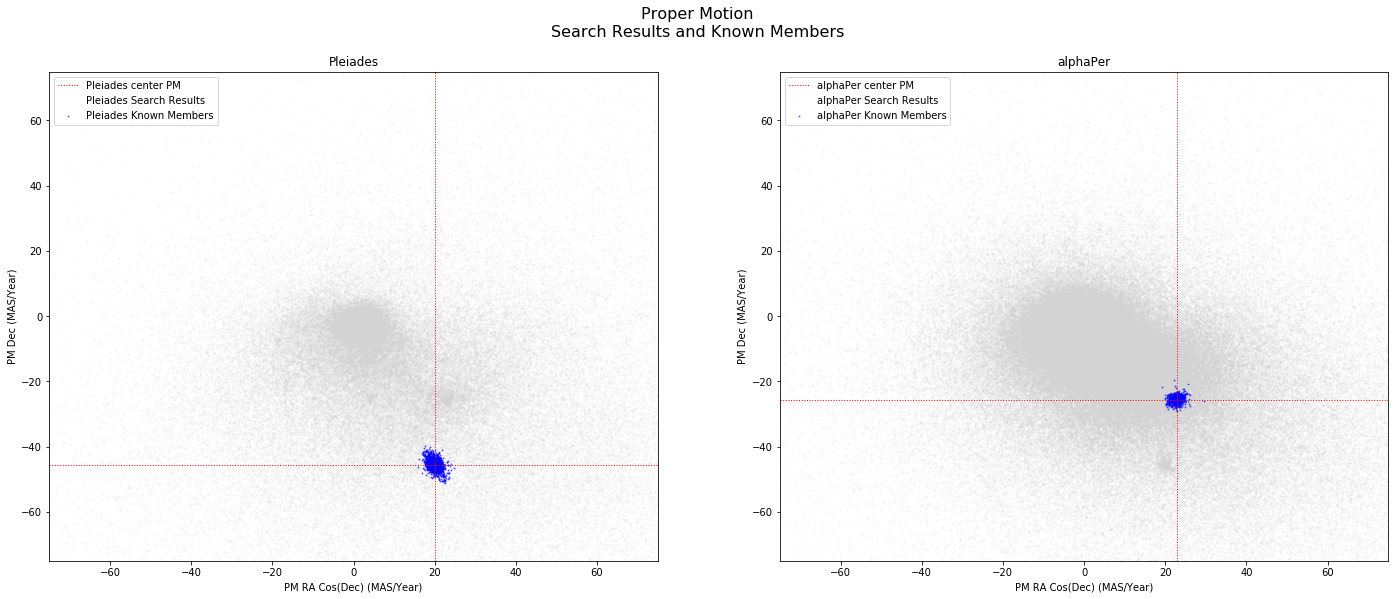

In [22]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    ax[i].scatter(search_results[cl].objs.pmra,  search_results[cl].objs.pmdec, color='lightgrey', alpha=0.1, s=1, label=f'{cl} Search Results',)
    ax[i].scatter(cluster_members[cl].objs.pmra, cluster_members[cl].objs.pmdec, color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl, size=12)
    ax[i].axvline(cluster_info.loc[cl]['pmra'], color='red', ls=':', lw=1)
    ax[i].axhline(cluster_info.loc[cl]['pmdec'], color='red', ls=':', lw=1, label=f'{cl} center PM')
    ax[i].set_xlabel('PM RA Cos(Dec) (MAS/Year)')
    ax[i].set_ylabel('PM Dec (MAS/Year)')
    ax[i].set_xlim(-75, 75)
    ax[i].set_ylim(-75,75)
    ax[i].legend()

    
fig.suptitle("Proper Motion\nSearch Results and Known Members", size=16)

In [ ]:
cluster_info.loc['Pleiades']

Text(0.5, 0.98, 'Color-Magnitude Diagrams\nSearch Results and Known Members')

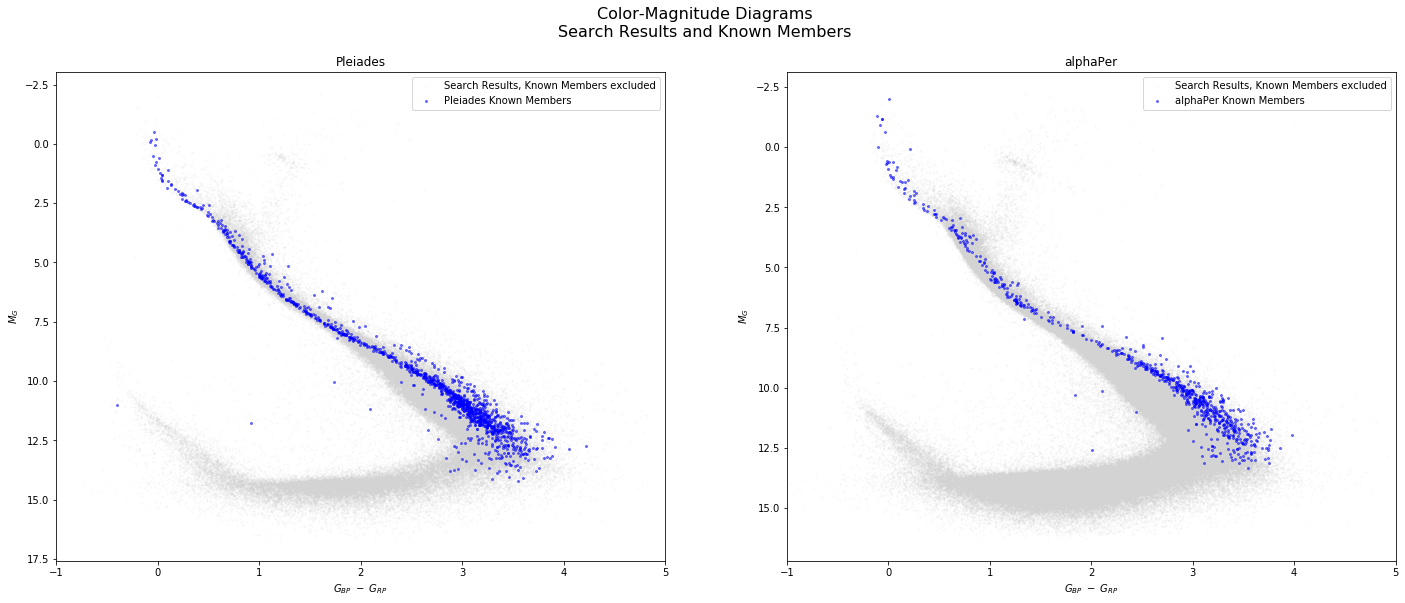

In [23]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=4)
    ax[i].set_title(cl, size=12)
    ax[i].legend()
    
fig.suptitle("Color-Magnitude Diagrams\nSearch Results and Known Members", size=16)


In [ ]:
print(cluster_info.loc[['Pleiades','alphaPer']][['cluster','ra','dec', 'plx','pmra','pmdec','RV','NMemb','log_age']].to_pandas().to_latex())

In [ ]:
cluster_info.columns

## 3 D Analysis

In [24]:
def cluster_age_bracket(cluster_info, cluster_name, tol=(0.8, 1.2)):
    cluster_age = 10**cluster_info.loc[cluster_name]['log_age']
    return (cluster_age*tol[0], cluster_age, cluster_age*tol[1])

In [25]:
cluster_age_bracket(cluster_info,'Pleiades')

(87718255.69145463, 109647819.61431828, 131577383.53718193)

In [26]:
cluster_age_bracket(cluster_info,'alphaPer')

(56635662.75073099, 70794578.43841374, 84953494.12609649)

In [27]:
import pickle
coeval_results = {}
travel_times = {}

for cl in cluster_names:
    with open(f'./data/coeval_{cl}.pkl', 'rb') as pkl:
        coeval_results[cl]=pickle.load(pkl)
    with open(f'./data/travel_time_{cl}.pkl', 'rb') as pkl:
        travel_times[cl] = pickle.load(pkl)
    cab = cluster_age_bracket(cluster_info, cl)
    search_results[cl].objs = pd.concat([search_results[cl].objs, coeval_results[cl], travel_times[cl]], axis=1)
    search_results[cl].objs['Candidate_3d'] = np.logical_and(search_results[cl].objs.min_sep <= 20,
                                                    np.logical_and(search_results[cl].objs.lookback_time >= cab[0],
                                                                  search_results[cl].objs.lookback_time <= cab[2]))

In [28]:
travel_times['alphaPer'].query('tt_3d_candidate')

,tt_3d_candidate,tt_3d_min,rv_min,tt_3d_max,rv_max
source_id,,,,,
66864364401034368,True,5.694165e+07,8.36,8.453979e+07,11.72
69097713030992256,True,5.694847e+07,6.88,7.494315e+07,9.32
69399288456115072,True,5.669681e+07,7.92,8.280123e+07,9.68
69912584291549440,True,5.718200e+07,7.80,8.410408e+07,11.12
70068650520031104,True,5.751367e+07,8.28,8.422064e+07,10.44
...,...,...,...,...,...
996893486002670592,True,5.664997e+07,2.08,5.725131e+07,2.52
997087206207079936,True,5.679009e+07,0.20,8.418052e+07,4.28
999057118727049088,True,5.665035e+07,0.64,5.803949e+07,1.44


In [29]:
travel_times['alphaPer'].query('~tt_3d_candidate').head()

,tt_3d_candidate,tt_3d_min,rv_min,tt_3d_max,rv_max
source_id,,,,,
62970959365145088,False,NaN,NaN,NaN,NaN
62973295826092672,False,NaN,NaN,NaN,NaN
62976040309623808,False,NaN,NaN,NaN,NaN
62977144118040960,False,NaN,NaN,NaN,NaN
62977659514111616,False,NaN,NaN,NaN,NaN


In [30]:
10**cluster_info.loc['alphaPer']['log_age']*np.array([0.8,1.2])

array([56635662.75073099, 84953494.12609649])

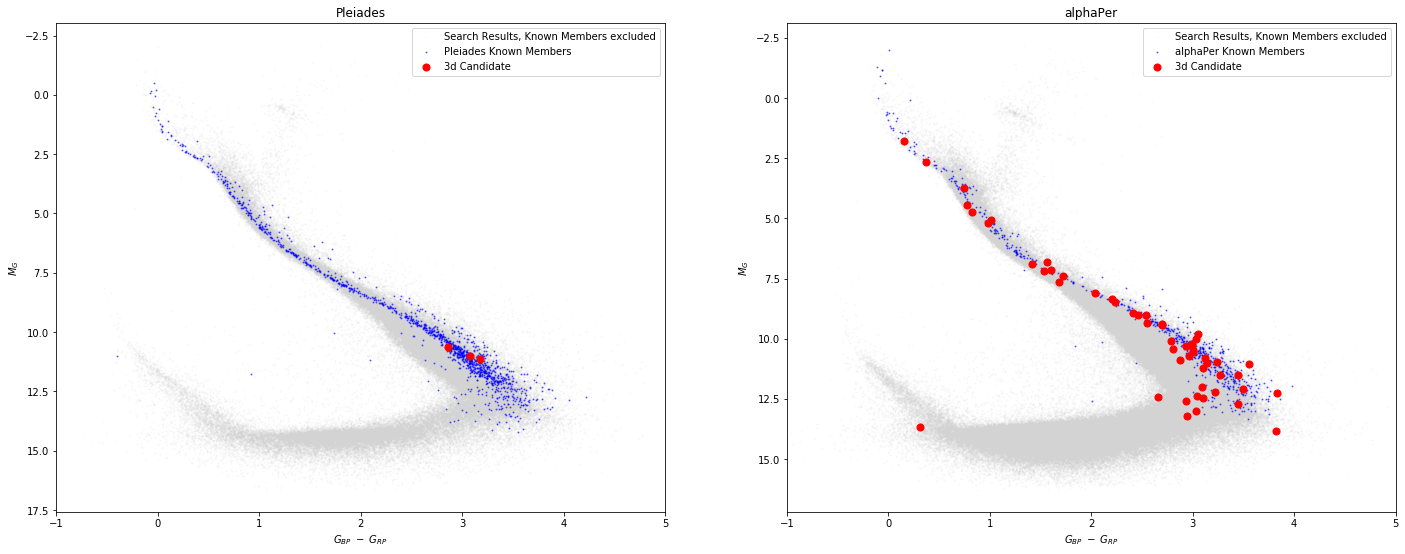

In [31]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    search_results[cl].query('Candidate_3d').plot_hrdiagram(ax=ax[i],color='red',s=50, alpha=1.0, r_est=False,label='3d Candidate')
    ax[i].set_title(cl)
    ax[i].legend()

In [32]:
cluster_info.loc['Pleiades']

cluster,ra,dec,U,e_U,V,e_V,W,e_W,cUV,cUW,cVW,ra_conv,dec_conv,plx,e_plx,pmra,e_pmra,pmdec,e_pmdec,NMemb,uwsd,RV,e_RV,coords,DM,log_age,Fe_H,e_b_minus_v,NMembers,Z
,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg,pc",,,,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64
Pleiades,56.44,23.86,-1.311,0.07,21.39,0.105,-24.456999999999997,0.057,0.48,0.5,0.9,93.5183,-48.7831,7.364,0.005,19.997,0.127,-45.548,0.10099999999999999,1326,0.77,5.65,0.09,"56.44,23.86,135.79576317218903",5.667000000000001,8.04,-0.01,0.045,1059,0.017


In [33]:
cluster_info.loc['Pleiades']['coords'].cartesian

<CartesianRepresentation (x, y, z) in pc
    (68.65357087, 103.48860333, 54.92982325)
 (has differentials w.r.t.: 's')>

In [34]:
coords = cluster_members['Pleiades'].get_coords()

In [35]:
(coords.cartesian.xyz.value.T).shape

(1326, 3)

In [36]:
pd.DataFrame(coords.cartesian.xyz.value.T, columns=['X',"Y","Z"], index=pd.Index(cluster_members['Pleiades'].objs.index, name="source_id")).to_csv('Pleiades_xyz.csv')

## Color Model

In [37]:
from colormagmodel import cm_model

#fit the color models
cm_models = {}
for cl in cluster_names:
    cm_models[cl] = cm_model(f'{cl} Color Model')
    cm_models[cl].fit(*cluster_members[cl].get_colors())

In [38]:
for cl in cluster_names:
    cm_ok = cm_models[cl].predict(*search_results[cl].get_colors())
    search_results[cl].objs['ColorMag'] =cm_ok

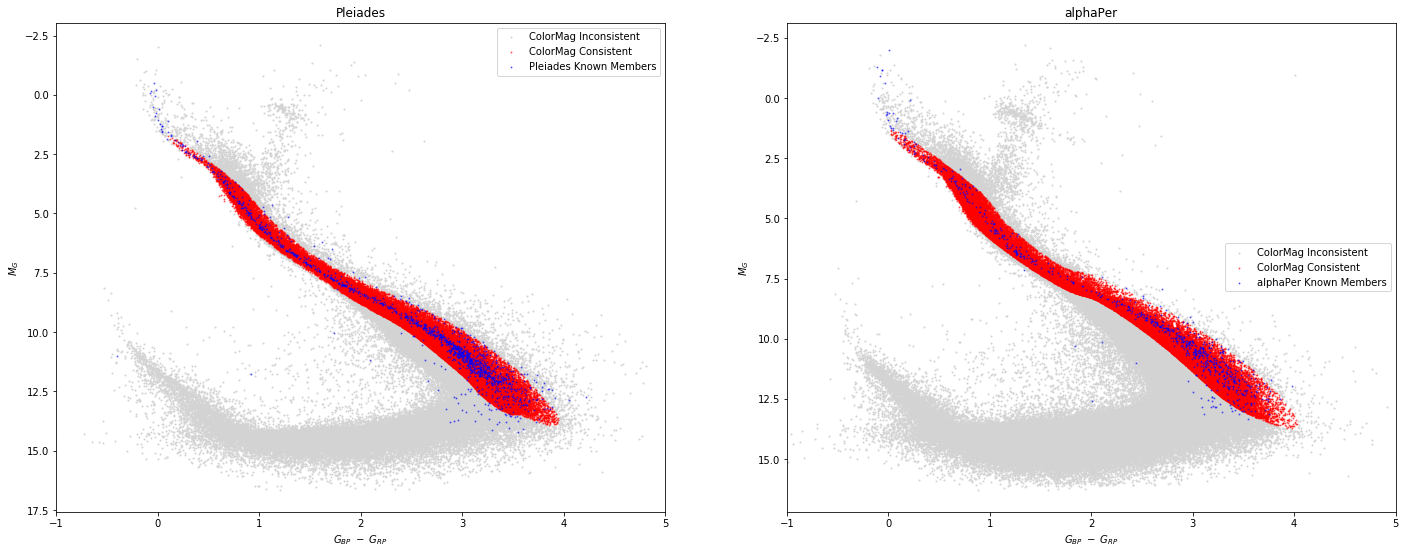

In [39]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    #search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)

    search_results[cl].query('~ColorMag').plot_hrdiagram(ax=ax[i],s=1, alpha=1.0, r_est=False,
                                        label='ColorMag Inconsistent', color='lightgrey')
    search_results[cl].query('ColorMag').plot_hrdiagram(ax=ax[i],s=1, alpha=.50, r_est=False,
                                        label='ColorMag Consistent',color='red')
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl)
    ax[i].legend()

In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    search_results[cl].query('Candidate_3d and ~ColorMag').plot_hrdiagram(ax=ax[i],s=50, alpha=1.0, r_est=False,
                                                                          label='3d Candidate, ColorMag Not OK',
                                                           facecolor='none', edgecolor='red')
    search_results[cl].query('Candidate_3d and ColorMag').plot_hrdiagram(ax=ax[i],s=50, alpha=1.0, r_est=False,
                                                                         label='3d Candidate, ColorMag OK',
                                                           facecolor='red', edgecolor='red')
    ax[i].set_title(cl)
    ax[i].legend()

In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)

    search_results[cl].query('Candidate_3d and ColorMag').plot_hrdiagram(ax=ax[i],s=50, alpha=1.0, r_est=False,
                                                                         label='3d Candidate, ColorMag OK',
                                                           facecolor='red', edgecolor='red')
    ax[i].set_title(cl)
    ax[i].legend()

### Distance from Center

In [ ]:
# calc distance from center for known members and search results
for cl in cluster_names:
    cen = cluster_info.loc[cl]['coords']
    mem_coords = cluster_members[cl].get_coords()
    mem_dist = cen.separation_3d(mem_coords)
    cluster_members[cl].objs['CenDist']=mem_dist
    
    sr_coords = search_results[cl].get_coords()
    sr_dist = cen.separation_3d(sr_coords)
    search_results[cl].objs['CenDist'] = sr_dist

In [ ]:
import seaborn as sns

In [ ]:
mem_dist_df = pd.concat([pd.DataFrame({'Cluster':cl,'CenDist':cluster_members[cl].objs.CenDist}) for cl in cluster_members])

cand_dist_df = pd.concat([pd.DataFrame({'Cluster':cl,
                    'CenDist':search_results[cl].objs.query('Candidate_3d and ColorMag').CenDist}) for cl in cluster_members])

In [ ]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()
sns.boxplot(ax=ax, data=mem_dist_df, x="Cluster", y="CenDist")
sns.stripplot(ax=ax, data=cand_dist_df, x="Cluster", y="CenDist", size=7, color='red', label='Runaway Candidates')
ax.set_ylabel('Distance from Center (pc)')
ax.legend(loc='upper left')

In [ ]:
cand_dist_df

In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    candidates = search_results[cl].objs.query('Candidate_3d and ColorMag')
    ax[i].scatter(search_results[cl].objs.ra,  search_results[cl].objs.dec, color='lightgrey', alpha=0.1, s=1)
    ax[i].scatter(cluster_members[cl].objs.ra, cluster_members[cl].objs.dec, color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].scatter(candidates.ra, candidates.dec, color='red', label=f'{cl} Runaway Candidates',alpha=1.0, s=20)
    ax[i].set_title(cl, size=12)
    ax[i].set_xlabel('Right Ascension (Degree)')
    ax[i].set_ylabel('Declination (Degree)')
    ax[i].legend()
    ax[i].invert_xaxis()
    
fig.suptitle("Sky Position\nSearch Results, Known Members and Runaway Candidates", size=16)

In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    
    candidates = search_results[cl].objs.query('Candidate_3d and ColorMag')
    
    ax[i].scatter(search_results[cl].objs.pmra,  search_results[cl].objs.pmdec, color='lightgrey', alpha=0.1, s=1, label=f'{cl} Search Results',)
    ax[i].scatter(cluster_members[cl].objs.pmra, cluster_members[cl].objs.pmdec, color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].scatter(candidates.pmra, candidates.pmdec, color='red', label=f'{cl} Runaway Candidates',alpha=1.0, s=20)
    ax[i].set_title(cl, size=12)
    #ax[i].axvline(cluster_info.loc[cl]['pmra'], color='red', ls=':', lw=1)
    #ax[i].axhline(cluster_info.loc[cl]['pmdec'], color='red', ls=':', lw=1, label=f'{cl} center PM')
    ax[i].set_xlabel('PM RA Cos(Dec) (MAS/Year)')
    ax[i].set_ylabel('PM Dec (MAS/Year)')
    ax[i].set_xlim(-75, 75)
    ax[i].set_ylim(-75,75)
    ax[i].legend()

    
fig.suptitle("Proper Motion\nSearch Results, Known Members and Runaway Candidates", size=16)

In [ ]:
cand_dist_df

In [ ]:
cand_dist_df.Cluster.value_counts()

In [ ]:
search_results['alphaPer'].objs.loc[141479766080535296]

In [ ]:
star_i=search_results['alphaPer'].objs.index.get_loc(141479766080535296)

In [ ]:
sr_coords[star_i]

In [ ]:
sr_coords[star_i].separation_3d(cluster_info.loc['alphaPer']['coords'])

In [ ]:
cluster_info.loc['alphaPer']['coords'].separation_3d(sr_coords[star_i])

In [ ]:
sr_dist[star_i]

In [ ]:
tbl_cols = ['ra','dec','parallax','pmra','pmdec']

In [ ]:
print(search_results['Pleiades'].objs.query('Candidate_3d and ColorMag')[tbl_cols].to_latex(float_format="%.2f"))

In [ ]:
print(search_results['alphaPer'].objs.query('Candidate_3d and ColorMag')[tbl_cols+['radial_velocity']].to_latex(float_format="%.2f"))

In [ ]:
search_results['Pleiades'].tap_query_string

# Everything below here stale?

## Evaluate `travel_time` Relationship

In [ ]:
tt_thresh=0.7e8

for cl in cluster_names:
    search_results[cl].travel_time(cluster_info.loc[cl]['coords'], inplace=True)

In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    ax[i].hist(search_results[cl].objs.travel_time, bins=100, log=True, label=cl)
    ax[i].set_title(cl)
    ax[i].set_xlabel('Travel Time (Years)')
    ax[i].set_ylabel('Log10( Number of Stars)')

    ax[i].grid(axis='y')
    ax[i].axvline(tt_thresh, color='red', ls=":", label=f'Threshold={tt_thresh:.2e} years')
    ax[i].legend()
zz = fig.suptitle('Distribution of Travel Times (log scale)')

In [ ]:
for cl in cluster_names:
    n_tt = len(search_results[cl].objs.query('travel_time>@tt_thresh'))
    n = len(search_results[cl].objs)
    print(f'Cluster: {cl}, Total Candidates: {n:,}, Travel Time > {tt_thresh:.2e}: {n_tt:,}, Percent: {100.0*n_tt/n:.2f}')

## Evaluate `points_to` Relationship

In [ ]:
for cl in cluster_names:
    maxsep = cluster_members[cl].maxsep(center = cluster_info.loc[cl]['coords'] )
    search_results[cl].points_to(cluster_info.loc[cl]['coords'],maxsep.value, inplace=True, allcalcs=False)
    n_pt = len(search_results[cl].objs.query('points_to'))
    n = len(search_results[cl].objs)
    print(f'Cluster: {cl}, Total Candidates: {n:,}, Cluster Radius: {maxsep.degree:.2f} degree, Points_to {n_pt:,}, Percent: {100.0*n_pt/n:.2f}')



In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('~points_to').plot_hrdiagram(ax=ax[i], color='grey', alpha=0.5, s=1, label="Not Pointing To")
    search_results[cl].query('points_to').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=1, label='Pointing To')
    ax[i].set_title(cl)
    ax[i].legend()

## Color Model

In [ ]:
for cl in cluster_names:
    cm_ok = cm_models[cl].predict(*search_results[cl].get_colors())
    search_results[cl].objs['ColorMag'] = np.logical_and(cm_ok, search_results[cl].objs.points_to)
    
    #apply age filter
    search_results[cl].objs['TBTok'] = np.logical_and(search_results[cl].objs.ColorMag, search_results[cl].objs.travel_time >= tt_thresh)

In [ ]:
#summarize results
for cl in cluster_names:
    scores = np.array([search_results[cl].objs.points_to, search_results[cl].objs.ColorMag, search_results[cl].objs.TBTok]).sum(axis=0)
    search_results[cl].objs['Score'] = scores

## Plot Results

In [ ]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('Score == 0').plot_hrdiagram(ax=ax[i], color='black', alpha=0.1, s=1, label="Not Pointing To")
    #cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members', alpha=0.5, s=1)
    search_results[cl].query('Score == 1').plot_hrdiagram(ax=ax[i], color='green', alpha=0.7, s=1, label="Pointing To")
    search_results[cl].query('Score == 2').plot_hrdiagram(ax=ax[i], color='cyan', alpha=0.7, s=1, label="ColorMag")
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=100,marker='*', label="Traceback Time")

    ax[i].set_title(cl, fontsize=14)
    ax[i].legend(fontsize=12, title='Filter')

In [ ]:
filters = ['SearchResults','PointingTo','ColorModel','TracebackTime']
for i,f in enumerate(filters):
    n_Pleiades = len(search_results['Pleiades'].objs.query('Score >= @i'))
    n_alphaPer = len(search_results['alphaPer'].objs.query('Score >= @i'))
    print(f'Measure: {f}, Pleiades: {n_Pleiades}, alphaPer: {n_alphaPer}')

In [ ]:
fig = plt.figure(figsize=(16,9))
axs = fig.subplots(1,2)

for ax,cl in zip(axs, cluster_names):
    cluster_members[cl].plot_hrdiagram(ax=ax, color='blue', label=f'{cl} Known Members', alpha=1, s=1)
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax, color='red', alpha=1, s=100,marker='*', label="Candidate Member")

    ax.legend()
    ax.set_title(f'{cl} Known Members and Candidates')

## Trajectory

In [ ]:
def cartesian_to_spherical(xyz):
    r = np.sqrt((xyz**2).sum(axis=0))
    delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
    alpha = np.arctan2(xyz[1], xyz[0])
    alpha = np.where(alpha<0, alpha+2.0*np.pi, alpha)
    
    spherical = {'distance':r,
                 'alpha': np.rad2deg(alpha),
                 'delta': np.rad2deg(delta)
    }
    
    return spherical

In [ ]:
def get_trajectory(coord, tval, default_rv= 5*u.km/u.second):
    c = coord.galactic
    xyz = c.cartesian.xyz.reshape(-1,1) # in pc
    
    pm_l_cosb = c.pm_l_cosb
    pm_b = c.pm_b
    
    d_xyz = c.velocity.d_xyz.to(u.pc/u.year).reshape(-1,1)
    
    xyz_t = xyz + d_xyz.dot(tval)
    
    spherical = cartesian_to_spherical(xyz_t.value)
    
    return spherical

In [ ]:
tval = np.linspace(-120e6, 0, 10001).reshape(1,-1)*u.year

In [ ]:
fig = plt.figure(figsize=(16,6))
axs = fig.subplots(1,2)

for cl,ax in zip(cluster_names, axs):
    c = cluster_info.loc[cl]['coords'].galactic
    sphere_t = get_trajectory(c, tval)
    
    pcm = ax.scatter(sphere_t['alpha'], sphere_t['delta'], s=8, c=tval[0])
    ax.scatter(c.l, c.b,s=200,marker='*', color='red', label=f'Current Position: {cl}')
    
    #plot trajectories of candidates:
    candidates = search_results[cl].query('Score == 3')
    cand_coords = candidates.get_coords().galactic
    for i, c in enumerate(cand_coords):
        sphere_t = get_trajectory(c, tval)
        ax.scatter(sphere_t['alpha'], sphere_t['delta'], s=1, c=tval[0])
                   
        ax.scatter(c.l, c.b,s=100,marker='*',label=list(candidates.objs.index)[i])
                   
    #ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
    #ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
    ax.set_title(f'{cl} Trajectory')
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Lattitude')
    ax.legend()
    ax.grid()
    ax.invert_xaxis()
fig.colorbar(pcm, label='Time (Years')

In [ ]:
candidates.objs.TraceBackTime

In [ ]:
def pm_to_dxyz(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity):
    """
    computes d_xyz from ra, dec,d distance, pmra_cosdec and pm_dec, given a sample of radial velocity
    Arguemnts:
  
    """
    v_ra = (pm_ra_cosdec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    v_dec = (pm_dec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    
    #form the derivative matrix
    sin_alpha = np.sin(ra); cos_alpha = np.cos(ra)
    sin_delta = np.sin(dec); cos_delta=np.cos(dec)
    
    #shape should be 3x3
    dm = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                  cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                  sin_delta,             0,            cos_delta]).reshape(3,3)

    n = len(radial_velocity)
    eq_v = np.array([radial_velocity.value, np.full(n,v_ra.value), np.full(n, v_dec.value)]) *u.km/u.second
    d_xyz = dm.dot(eq_v)
    
    return d_xyz

In [ ]:
def valid_rv(star, center, tt_min, rv_sample):
    """
    returns boolean vector indicating which members of rv_sample allow for a travel time from center to star greater than mintt
    """
    
    #get velocity column vectors for star for each element of rv_sample
    d_xyz_s = pm_to_dxyz(star.ra, star.dec, star.distance, star.pm_ra_cosdec, star.pm_dec, rv_sample)
    
    #center velocity column vector
    d_xyz_c = center.velocity.d_xyz.reshape(3,1)
    #velocity in center reference frame
    d_xyz_s_csr = d_xyz_s - d_xyz_c
    
    #space velocity and convert to pc/year
    vel_csr = np.sqrt((d_xyz_s_csr**2).sum(axis=0)).to(u.pc/u.year)
    
    #distance btwn center and star
    d=center.separation_3d(star) #comes back in pc
    
    #how long did it take given the sample of velocities
    tt_sample = d/vel_csr # should be in years
    
    rv_valid = tt_sample >= tt_min
    
    return rv_valid, tt_sample

In [ ]:
def separation_t( star, center, rv, travel_time):
    """
    calculates separation of center and star at each of the (traveltime, rv) pair
    travel_time is signed quantity <0 => time in past; >0 => time in future
    """
    tt = travel_time.to(u.year).reshape(1,-1)
    
    cen_pos = center.cartesian.xyz.reshape(3,1)
    cen_d_xyz = center.velocity.d_xyz.reshape(3,1).to(u.pc/u.year)
    
    cen_delta_pos = cen_d_xyz.dot(tt)
    cen_pos_t = cen_pos + cen_delta_pos
    
    star_pos = star.cartesian.xyz.reshape(3,1)
    star_d_xyz = pm_to_dxyz(star.ra, star.dec, star.distance, star.pm_ra_cosdec, star.pm_dec, rv)
    tt_stack = np.vstack([tt]*3)
    star_delta_pos = star_d_xyz*tt_stack
    star_pos_t = star_pos+star_delta_pos
    
    #calculate the separations
    delta_xyz = star_pos_t - cen_pos_t
    seps = np.sqrt((delta_xyz**2).sum(axis=0))
    
    return seps

In [ ]:
def traceback3d(star, center, tidal_r, rvsample):
    v_rv, tt_sample= valid_rv(star, center,  20e6*u.year, rvsample)
    
    seps = separation_t(star, center, rvsample, -1*tt_sample)
    
    valid_seps = seps <= tidal_r
    min_sep_i = seps.argmin()
    min_sep = seps[min_sep_i]
    min_sep_time = -1.0*tt_sample[min_sep_i]

    if np.any(valid_seps):
        rv_i = np.arange(len(rvsample))
        #get max travel time for seps <= tidal_r
        am = tt_sample[valid_seps].argmax()
        am_i = rv_i[valid_seps][am]
        rv = rvsample[am_i].value
        tt = tt_sample[am_i].value
    else:
        rv =  tt = np.nan
    
    return {'RequiredRadialVelocity': rv, 'ImpliedTravelTime': tt, 'MinSeparation':min_sep, 'MinSepTime':min_sep_time}

In [ ]:
rv_sample3 = np.concatenate([np.linspace(-100, -20, 800, endpoint=False),
                        np.linspace(-20,20,1000, endpoint=False),
                        np.linspace(20, 100, 800)])*u.km/u.second

In [ ]:
candidates = {}
tb_results = {}
for cl in cluster_names:
    candidates[cl] = search_results[cl].query('Score == 3')
    coords = candidates[cl].get_coords(recalc=True, default_rv=True)
    tb_results[cl] = pd.DataFrame([traceback3d(c, cluster_info.loc[cl]['coords'], 10*u.pc, rv_sample3) for c in coords],
                                 index = pd.Index(list(candidates[cl].objs.index), name =search_results[cl].objs.index.name ))


In [ ]:
tb_results['Pleiades']

In [ ]:
tb_results['alphaPer']

In [ ]:
def plot_rv(ax,star, center, source_id, rvsample, ttsample, seps, tidal_radius=10*u.pc, xlim=None):
    #color boundaries
    vmin = 10e6; vmax=100e6


    current_sep = star.separation_3d(center)
    act_rv = star.radial_velocity.value

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

    ax.scatter(rvsample, ttsample, label=f'Source ID: {source_id}',
               c=ttsample, cmap='RdYlGn',  vmin=vmin, vmax=vmax, ls='-')
    ax.axvline(act_rv, color='orange', ls='--', label='Observed RV')
    ax.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='off' )    
    ax.set_ylabel('Travel Time to Current Separation (Years)')

    ax.set_title(f'Source ID: {source_id}')
    ax.legend()
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_xticklabels([])

    divider = make_axes_locatable(ax)
    ax1 = divider.append_axes("bottom", size="50%", pad=0.08)
    cax = divider.append_axes("right", size="5%", pad=0.08)


    pcm = ax1.scatter(rvsample, seps, c=tt_sample,cmap='RdYlGn',  vmin=vmin, vmax=vmax,
                      label='Modeled')
    ax1.axvline(act_rv, color='orange', ls='--', label='Observed RV')
    ax1.axhline(current_sep.value, color='red', ls='--', label='Current Separation')
    ax1.axhline(tidal_radius.value, color='blue', ls='--', label='Tidal Radius')
    ax1.set_xlabel('Radial Velocity (km/s)')
    ax1.set_ylabel('Separation at Current Sep Travel Time (pc)')
    ax1.grid()
    ax1.legend()
    ax1.set_xlim(xlim)
    #zz=ax[1].set_title('Separation')
    cb = plt.colorbar( pcm, ax=ax1, cax=cax )
    cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    cb.ax.set_ylabel('Travel Time (Years)', rotation=-90)

In [ ]:
cl='alphaPer'
source_id = 349912948408076544

candidates[cl] = search_results[cl].query('Score == 3')
coords = candidates[cl].get_coords(recalc=True, default_rv=True)
star_i = candidates[cl].objs.index.get_loc(source_id)

v_rv, tt_sample= valid_rv(coords[star_i],cluster_info.loc[cl]['coords'],20e6*u.year,rv_sample3)
seps = separation_t(coords[star_i],cluster_info.loc[cl]['coords'],rv_sample3, -1*tt_sample)

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
plot_rv(ax,coords[star_i], cluster_info.loc[cl]['coords'], source_id, rv_sample3, tt_sample, seps, xlim=None)

In [ ]:
candidates['alphaPer']

In [ ]:
candidates['alphaPer'].travel_time3d(cluster_info.loc['alphaPer']['coords'], 50e6*u.year)

In [ ]:
candidates['alphaPer']._travel_time3d(coords[0],cluster_info.loc['alphaPer']['coords'], 10e6*u.year, rv_sample3)

In [ ]:
rv, tt = candidates['alphaPer']._travel_time3d(coords[0],cluster_info.loc['alphaPer']['coords'],    10e6*u.year, rv_sample3, ret_sample=True)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.scatter(rv, tt)